# 2D Convolution and Convoltional Layers

In this demo, you will learn to:
* Compute 2D convolutions on images using `scipy`.
* Visualize the outputs of convolutions
* Create a convolutional layer in pytorch
* Set the weights of the pytorch layer manually
* Mathematically describe the weights with multiple input and output channels

Note:  The repo also has a [tensorflow version](./demo1_convolutions_tf.ipynb) of this demo.

## Downloading the Images

We will download a simple image for the demo.  If you have cloned the repo, the image is already included and you can skip this part.  But, if you want to run the demo on Google colab, you will need to run these commands to bring them into the virtual machine.  First, we create a `download_file` method from the earlier units.

In [1]:
from tqdm import tqdm
import requests
import os

def download_file(src_url, dst_fn):

    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return

    print('Downloading %s' % dst_fn)

    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0));
    block_size = 1024
    wrote = 0
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB',
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong")

We then download the image.

In [2]:
src_url = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit10_cnn/still_life.jpg'
dst_fn = 'still_life.jpg'
download_file(src_url, dst_fn)

89.0kB [00:00, 7.11kkB/s]                  


## Loading and Displaying Images

We first import several packages.  Two important packages we will use are:
* `scipy.signal`: sub-package which has useful routines for 2D convolutions; and
* `skimage.data`: sub-package for getting some basic images.

In [3]:
import numpy as np
import scipy.signal
import skimage.data
import matplotlib.pyplot as plt

We next create a function to display images that we will use throughout the demo.  The function does both gray-scale and color images.

In [4]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)

    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

The `skimage.data` package has several commonly used images in image processing.  We begin by loading a widely-used "cameraman" image.  

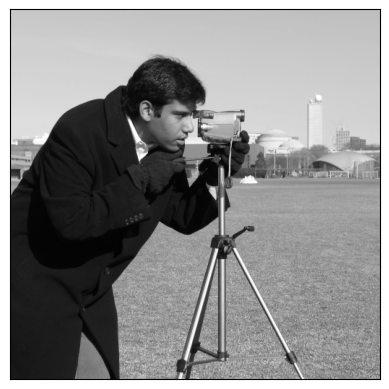

In [5]:
im = skimage.data.camera()
disp_image(im)

We print the image shape

In [6]:
print("The image shape is: "+str(im.shape))

The image shape is: (512, 512)


We can also load images from files using the `skimage.io.imread` function.  This function can handle most common image formats including, for example, JPG.

The image shape is: (368, 487, 3)


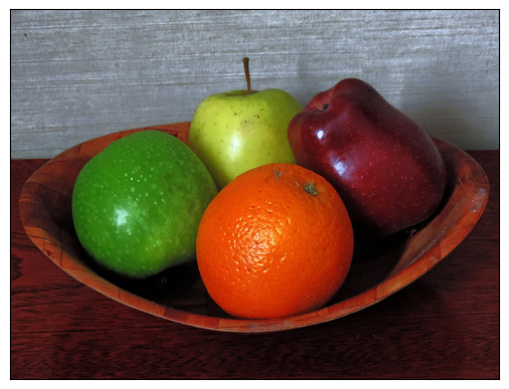

In [7]:
fname = 'still_life.jpg'
im_color = skimage.io.imread(fname)
disp_image(im_color)
print("The image shape is: "+str(im_color.shape))

## Performing 2D Convolutions

To illustrate 2D convolution, we first apply an averaging filter, which essentially replaces each pixel by the average of a neighborhood of `KxK` pixels to the top left of the current pixel. Filtering an image with this filter has a smoothing effect.  In image processing, convolving with an averaging filter can be useful as a crude noise removal filter. But, for convolutional networks, an averaging kernel finds regions of high intensity.

Not that we use the `correlate2d()` function.  The `scipy.signal` package also has a `convolve2d()` function.  But, in signal processing, the term *convolution* includes a sign reversal which is not included in deep networks.

Text(0.5, 1.0, 'Uniform kernel, Valid')

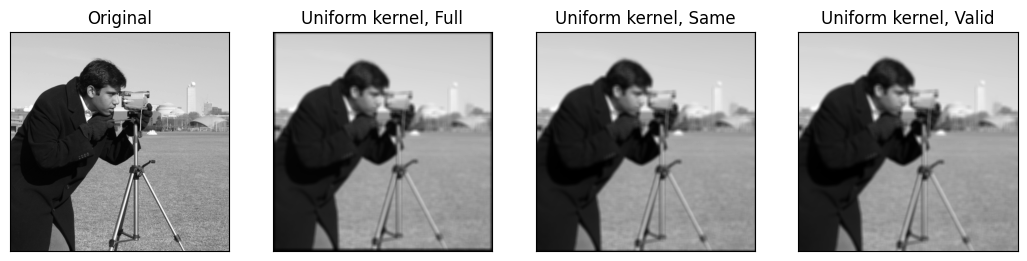

In [8]:
kx = 9
ky = 9
sig = 3
G_unif = np.ones((kx,ky))/(kx*ky)
im_unif_full = scipy.signal.correlate2d(im, G_unif, mode='full')
im_unif_same = scipy.signal.correlate2d(im, G_unif, mode='same')
im_unif_valid = scipy.signal.correlate2d(im, G_unif, mode='valid')

# Plot the original image and the three outputs
plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,4,2)
disp_image(im_unif_full)
plt.title('Uniform kernel, Full')
plt.subplot(1,4,3)
disp_image(im_unif_same)
plt.title('Uniform kernel, Same')
plt.subplot(1,4,4)
disp_image(im_unif_valid)
plt.title('Uniform kernel, Valid')

Let us look at the image sizes. Let `K` represent filter width, `Ni` image width, `No` output width. Then:

* `full`: `No = Ni+K-1`,
* `same`:  `No=Ni`
* `valid`:  `No=Ni-K+1`.

In [9]:
print("Input shape = " + str(im.shape))
print("Output shape (Full) = " + str(im_unif_full.shape))
print("Output shape (Same) = " + str(im_unif_same.shape))
print("Output shape (valid) = " + str(im_unif_valid.shape))

Input shape = (512, 512)
Output shape (Full) = (520, 520)
Output shape (Same) = (512, 512)
Output shape (valid) = (504, 504)


Now let us take a closer look at the output near the boundaries

Text(0.5, 1.0, 'Uniform kernel, Valid')

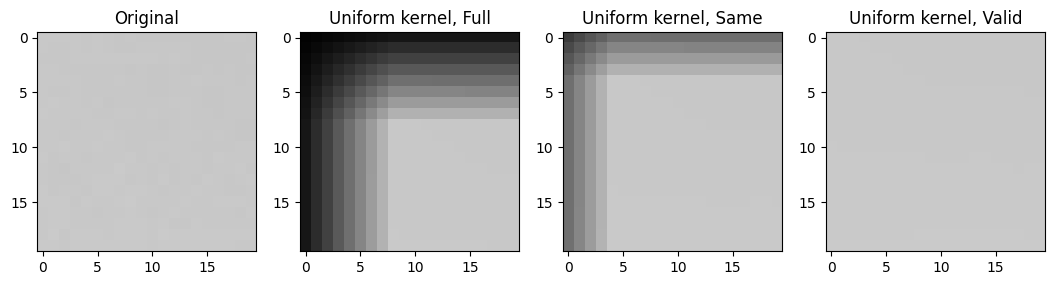

In [10]:
# Plot the original image and the three outputs at the top left corner
plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
plt.imshow(im[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(im_unif_full[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Uniform kernel, Full')
plt.subplot(1,4,3)
plt.imshow(im_unif_same[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Uniform kernel, Same')
plt.subplot(1,4,4)
plt.imshow(im_unif_valid[0:20,0:20], vmin=0, vmax=255, cmap='gray')
plt.title('Uniform kernel, Valid')

Now let us look at the effect of increasing the average window size. As we can see, the larger is `K`, the more bluured the image becomes.

Text(0.5, 1.0, 'Uniform kernel, 15x15')

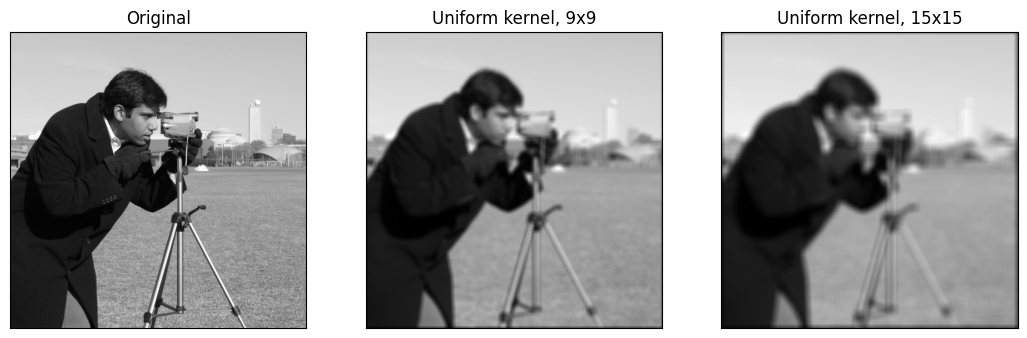

In [11]:
kx = 9
ky = 9

G_unif = np.ones((kx,ky))/(kx*ky)
im_unif_9 = scipy.signal.correlate2d(im, G_unif, mode='same')
kx = 15
ky = 15
G_unif = np.ones((kx,ky))/(kx*ky)
im_unif_15 = scipy.signal.correlate2d(im, G_unif, mode='same')

# Plot the original image and the three outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(im_unif_9)
plt.title('Uniform kernel, 9x9')
plt.subplot(1,3,3)
disp_image(im_unif_15)
plt.title('Uniform kernel, 15x15')

Compared to the averaging filter, the Gaussian kernel also performs an averaging, but weights the pixels at the center of the kernel more. You can control the bluring strength with the standard deviation sigma of the Gaussian kernel. Window size should generally be larger than 2 sigma.

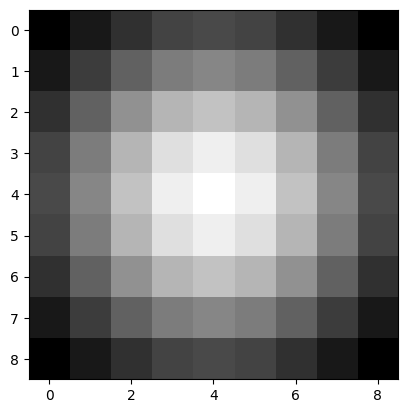

In [12]:
def gauss_kernel(nx,ny,sig):
    """
    Creates a Gaussian kernel of size (nx,ny) with std deviation sig
    """
    dxsq = (np.arange(nx)-(nx-1)/2)**2
    dysq = (np.arange(ny)-(ny-1)/2)**2
    dsq = dxsq[:,None] + dysq[None,:]
    G = np.exp(-0.5*dsq/(sig**2))
    G = G / np.sum(G)
    return G

# Create a Gaussian kernel
kx = 9
ky = 9
sig = 3
G_unif = np.ones((kx,ky))/(kx*ky)

# Create a Gaussian kernel
G_gauss = gauss_kernel(kx,ky,sig)
plt.imshow(G_gauss,interpolation='None',cmap='gray')

Now let us compare effect of averaging and Gaussian filtering, with different sizes

Text(0.5, 1.0, 'Gaussian kernel, 15x15')

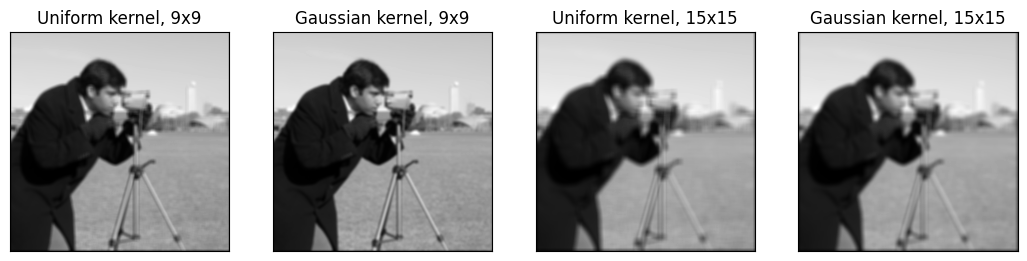

In [13]:
# Correlate with 9 x 9 Gaussian
kx = 9
ky = 9
sig = 3
G_gauss = gauss_kernel(kx,ky,sig)
im_gauss_9= scipy.signal.correlate2d(im, G_gauss, mode='same')

# Correlate with 15 x 15 Gaussian
kx = 15
ky = 15
sig = 6
G_gauss = gauss_kernel(kx,ky,sig)
im_gauss_15= scipy.signal.correlate2d(im, G_gauss, mode='same')


plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
disp_image(im_unif_9)
plt.title('Uniform kernel, 9x9')
plt.subplot(1,4,2)
disp_image(im_gauss_9)
plt.title('Gaussian kernel, 9x9')
plt.subplot(1,4,3)
disp_image(im_unif_15)
plt.title('Uniform kernel, 15x15')
plt.subplot(1,4,4)
disp_image(im_gauss_15)
plt.title('Gaussian kernel, 15x15')


In addtion to noise removal, a common use of convolution is edge detection by using a filter that approximates the operation of gradient in horizontal and vertical directions. One such filter set is called the [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator), `Gx` and `Gy`.  The filter `Gx` filter will have a large response when there is a large change in the x-direction (vertical edge).  Similarly, `Gy` will have a large response for a large change in the image in the y-direction (horizontal edge).   In any part of the image that is flat, the output is zero. Without filter reversal, the response is positive if the change is from black to white.

In [14]:
Gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])  # Gradient operator in the x-direction
Gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])  # Gradient operator in the y-direction

Text(0.5, 1.0, 'Gy * image')

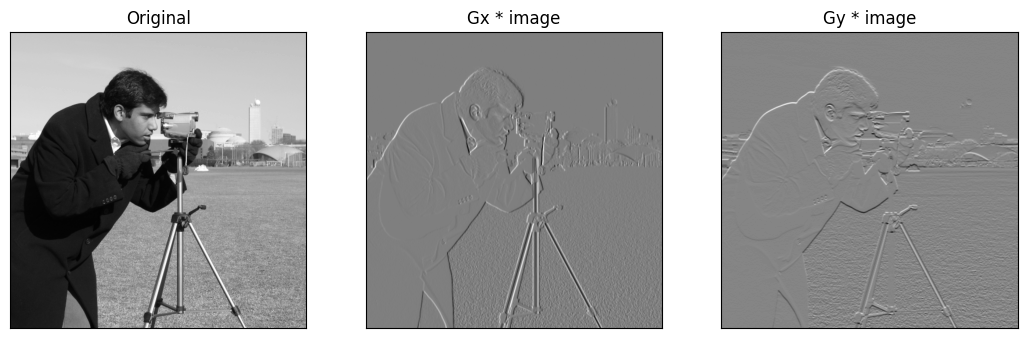

In [15]:
# Perform the convolutions
imx = scipy.signal.correlate2d(im, Gx, mode='valid')
imy = scipy.signal.correlate2d(im, Gy, mode='valid')

# Plot the original image and the two outputs
plt.figure(figsize=(13,13))
plt.subplot(1,3,1)
disp_image(im)
plt.title('Original')
plt.subplot(1,3,2)
disp_image(imx)
plt.title('Gx * image')
plt.subplot(1,3,3)
disp_image(imy)
plt.title('Gy * image')

Now let us see the result with the flipped filter. As can be seen, with filter reversal, the response is positive if the change is from white to black. This is in fact the result of correlating the filter mask with the local neighborhood.

## In-Class Exercise 1

In this exercise you will try to build your filter.
* Display the image of `X` constructed below.  If you display it correctly, you should see a white rectangle.
* Design a `4 x 4` filter, `G` such that if `Z = G*X`, `Z[i,j]=0` in the regions where `X`is constant and `Z[i,j]` takes it maximum value on the upper right corner of the rectangle.
* Print the filter `G`
* Display `Z = G*X` to confirm that it takes it maximum value on the top right corner.  

In [ ]:
imshape = (128,128)
bx = 16
by = 32
X = np.zeros(imshape)
X[by:-by,bx:-bx] = 1

## Implementing a Convolutional in Pytorch.

We now show how to implement a convolutional layer in pytorch.  Typically, in pytorch, images are represented as 4-th order tensors with dimensions `(batch_size,nchannels, height,width)`, where `batch_size` is the number of images in a batch, `(height,width)` is the images size per channel and `nchannels` is the number of image channels.  This format is sometimes called *channels first*.  In tensorflow, the channels are usually the final dimension.
 For BW images, there is only one channel. We first reshape the image to this format.

In [23]:
nrow, ncol = im.shape
nimage = 1         # number of images in batch
nchan_in = 1       # number of input channels.  1 since it is BW
input_shape = (nchan_in,nrow,ncol)  # input shape of 1 image
batch_shape = (nimage,nchan_in,nrow,ncol)  # shape of image batch
x = im.reshape(batch_shape)

We now create a convolutional layer in pytorch and two output channels.  Note that the padding is taken so that output and input have the same dimensions.

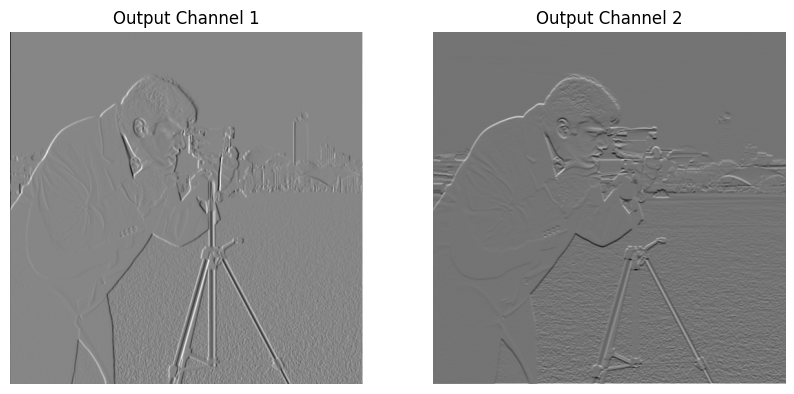

In [27]:
# prompt: Convert the code below to pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F


# Implementing a Convolutional Layer in PyTorch
im = skimage.img_as_float32(im) # Normalize pixel values to [0, 1]
im_tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0) # Add batch and channel dimensions

# Define a convolutional layer
nout = 2
nin = 1
kernel_size = (3,3)
padding = ((kernel_size[0]-1)//2, (kernel_size[1]-1)//2)
conv_layer = nn.Conv2d(in_channels=nin, out_channels=nout,
                       kernel_size=kernel_size, padding=padding)


# Set the weights
weights = np.zeros((nout, nin, kernel_size[0], kernel_size[1]), dtype=np.float32)
biases = np.zeros(nout, dtype=np.float32)
weights[0,0,:,:] = Gx
weights[1,0,:,:] = Gy
conv_layer.weight.data = torch.from_numpy(weights)
conv_layer.bias.data = torch.from_numpy(biases)

# Perform the convolution
output_tensor = conv_layer(im_tensor)

# Convert the output tensor back to a NumPy array
output_np = output_tensor.squeeze().detach().numpy()

# Display the output channels
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axes[i].imshow(output_np[i], cmap='gray')
    axes[i].set_title(f'Output Channel {i+1}')
    axes[i].axis('off')
plt.show()

Let's print the convolution layer.

In [25]:
print(conv_layer)

Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


## Using Multiple Input and Output Channels

We now create a keras model with a single convolutional layer to process the color image.  Note that we use the `transpose` commands to move the channels first.

Image shape is (368, 487, 3)


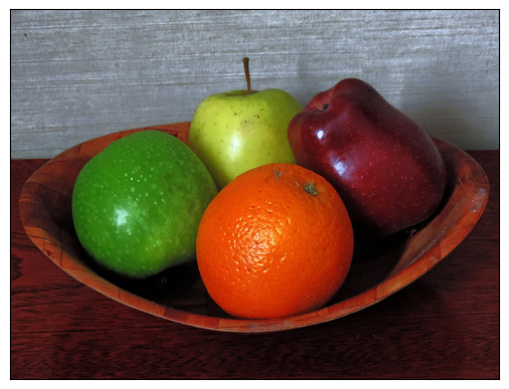

In [52]:
disp_image(im_color)
nrow,ncol,nchan_in = im_color.shape
nimage = 1

input_shape = (nchan_in,nrow,ncol)
batch_shape = (nimage,nchan_in,nrow,ncol)
print("Image shape is "+str(im_color.shape))

x = skimage.img_as_float32(im_color)
x = x.transpose(2,0,1).reshape(batch_shape)

We now create a network with a single convolutional layer with `nchan_out=4` output channels.

In [30]:
# Dimensions
nchan_out = 4
kernel_size = (9,9)
padding = ((kernel_size[0]-1)//2, (kernel_size[1]-1)//2)
conv_layer = nn.Conv2d(in_channels=nchan_in, out_channels=nchan_out,
                       kernel_size=kernel_size, padding=padding)
print(conv_layer)

Conv2d(3, 4, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))


Let's look at the shapes.

In [32]:
print(conv_layer.weight.shape)
print(conv_layer.bias.shape)

torch.Size([4, 3, 9, 9])
torch.Size([4])


To illustrate the 2D convolutions, we create kernels of the form:

    W[i,j,a,b] = G[a,b]*color_wt[i,j]
    
where `color_wt[i,j]` represents the weighting of color channel `j` for output channel `i` and `G[:,:]` is a uniform kernel over space.

In [40]:
# Color weights
color_wt = np.array([
    [1,    -0.5, -0.5],   # Sensitive to red
    [-0.5,    1, -0.5],   # Sensitive to green
    [-0.5, -0.5,    1],   # Sensitive to blue
    [ 0.5,   -1,  0.5],   # Sensitive to red-blue mix
])

# Gaussian kernel over space
krow, kcol = kernel_size
G = gauss_kernel(krow,kcol,sig=2)

# Multiply by weigthing color
W = G[None,None,:,:]*color_wt[:,:,None,None]
W = W.astype(np.float32)
b = np.zeros(nchan_out, dtype=np.float32)

# Set the convolutional layer weigths
conv_layer.weight.data = torch.from_numpy(W)
conv_layer.bias.data = torch.from_numpy(b)

We plot the filters.  The filter for each output channel is itself a small RGB image and indicates which local feature it is sensitive to.

array([[0.5568628 , 0.5058824 , 0.4666667 , 0.4784314 , 0.49803925],
       [0.5411765 , 0.5176471 , 0.46274513, 0.4784314 , 0.4666667 ],
       [0.43921572, 0.4431373 , 0.43921572, 0.41960788, 0.4039216 ],
       [0.4666667 , 0.47058827, 0.47450984, 0.4666667 , 0.454902  ],
       [0.48235297, 0.49411768, 0.4784314 , 0.5058824 , 0.45098042]],
      dtype=float32)

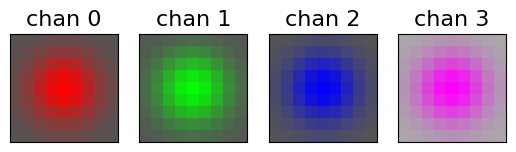

In [42]:
for i in range(nchan_out):
    plt.subplot(1,nchan_out,i+1)
    Wi = W[i,:,:,:].transpose(1,2,0)
    disp_image(Wi)
    title_str = 'chan %d' % i
    plt.title(title_str,fontsize=16)

We now run the image through the network.  We see that the output feature maps clearly indicate the different colors.

In [53]:
x.shape

(1, 3, 368, 487)

(1, 4, 368, 487)


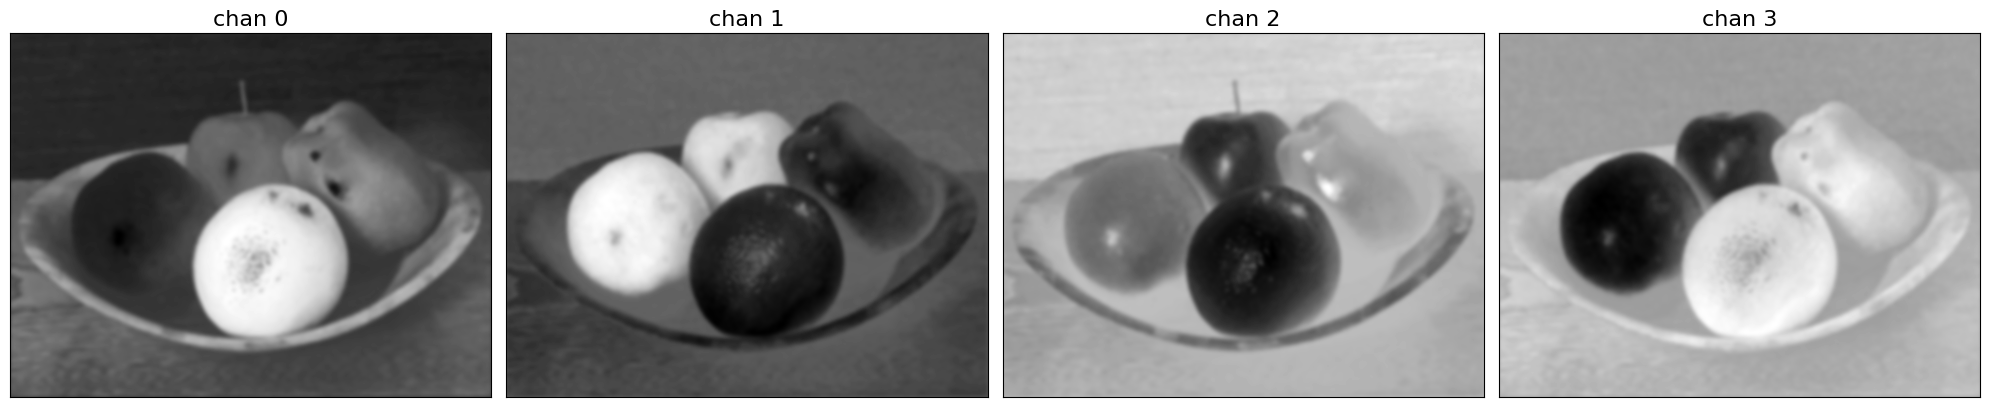

In [55]:
x_torch = torch.from_numpy(x)
y = conv_layer(x_torch)
y = y.detach().numpy()
print(y.shape)

plt.figure(figsize=(20,20))
for i in range(nchan_out):
    plt.subplot(1,nchan_out,i+1)
    disp_image(y[0,i,:,:])
    title_str = 'chan %d' % i
    plt.title(title_str,fontsize=16)
plt.tight_layout()

## In-Class Exercise 2

Create horizontal gradient filters in each of the four colors above.  Plot the gradient filters.  Also, filter the images with the color gradients and display the results.

In [ ]:
# TODO